In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Check GPU availability
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Only image data training

In [5]:
import os
import zipfile
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Paths
zip_path = '/content/drive/My Drive/IS/summed_diff_images.zip'  # Path to the ZIP file in Google Drive
unzip_path = '/content'  # Directory to extract contents

In [7]:
# Step 1: Extract the Dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

# Paths to individual trial folders
trial1_path = os.path.join(unzip_path, 'trial1_summed_diff_images')
trial2_path = os.path.join(unzip_path,'trial2_summed_diff_images')
trial3_path = os.path.join(unzip_path, 'trial3_summed_diff_images')

In [14]:
def load_data_from_trial(trial_path):
    data = []
    labels = []
    skipped_files = []

    for root, _, files in os.walk(trial_path):
        # Extract activity label from the folder name
        try:
            folder_name = os.path.basename(root)
            activity_label = int([part for part in folder_name.split('_') if "Activity" in part][0].replace('Activity', '')) - 1
        except (IndexError, ValueError) as e:
            skipped_files.append((root, str(e)))
            continue

        for file in files:
            if file.endswith('.jpg'):
                file_path = os.path.join(root, file)
                try:
                    # Load the image and normalize to [0, 1]
                    image = plt.imread(file_path) / 255.0
                    data.append(image)
                    labels.append(activity_label)
                except Exception as e:
                    skipped_files.append((file_path, str(e)))

    # Log skipped files
    if skipped_files:
        print(f"Skipped {len(skipped_files)} files or folders due to errors:")
        for file_path, error in skipped_files[:10]:  # Limit output for clarity
            print(f"File or Folder: {file_path}, Error: {error}")

    return np.array(data), np.array(labels)

In [15]:
# Step 2: Load Data
X_trial1, y_trial1 = load_data_from_trial(trial1_path)
X_trial2, y_trial2 = load_data_from_trial(trial2_path)
X_trial3, y_trial3 = load_data_from_trial(trial3_path)

# Combine trial1 and trial2 for training and validation
X_train_val = np.concatenate((X_trial1, X_trial2), axis=0)
y_train_val = np.concatenate((y_trial1, y_trial2), axis=0)

# Use trial3 as the test set
X_test, y_test = X_trial3, y_trial3

# Split training and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Print data shapes
print("Training data shape:", X_train.shape, "Training labels shape:", y_train.shape)
print("Validation data shape:", X_val.shape, "Validation labels shape:", y_val.shape)
print("Test data shape:", X_test.shape, "Test labels shape:", y_test.shape)

Skipped 1 files or folders due to errors:
File or Folder: /content/trial1_summed_diff_images, Error: list index out of range
Skipped 1 files or folders due to errors:
File or Folder: /content/trial2_summed_diff_images, Error: list index out of range
Skipped 1 files or folders due to errors:
File or Folder: /content/trial3_summed_diff_images, Error: list index out of range
Training data shape: (3100, 32, 32) Training labels shape: (3100,)
Validation data shape: (776, 32, 32) Validation labels shape: (776,)
Test data shape: (1931, 32, 32) Test labels shape: (1931,)


Displaying samples from Training Set:


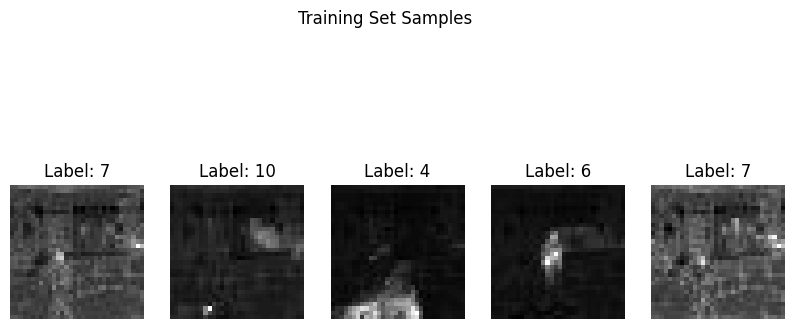

In [16]:
# Display samples from the training set
def display_random_samples(X, y, title="Samples"):
    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i], cmap='gray')  # Display the summed difference image
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

print("Displaying samples from Training Set:")
display_random_samples(X_train, y_train, title="Training Set Samples")

In [17]:
# Step 3: Define CNN Model
num_classes = len(np.unique(y_train))  # Number of activity classes
input_shape = X_train.shape[1:]  # Shape of one image

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(input_shape[0], input_shape[1], 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
# Define callbacks
checkpoint_path = "/content/best_model_summed_diff.keras"
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    X_train[..., np.newaxis], y_train,  # Add channel dimension for grayscale images
    epochs=70,
    batch_size=16,
    validation_data=(X_val[..., np.newaxis], y_val),
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/70
194/194 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.2731 - loss: 2.0082 - val_accuracy: 0.4923 - val_loss: 1.4665
Epoch 2/70
194/194 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5065 - loss: 1.4010 - val_accuracy: 0.5928 - val_loss: 1.2540
Epoch 3/70
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5994 - loss: 1.2096 - val_accuracy: 0.5954 - val_loss: 1.1714
Epoch 4/70
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6455 - loss: 1.0908 - val_accuracy: 0.6637 - val_loss: 1.0489
Epoch 5/70
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6694 - loss: 1.0529 - val_accuracy: 0.6649 - val_loss: 0.9683
Epoch 6/70
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6865 - loss: 0.9384 - val_accuracy: 0.7242 - val_loss: 0.8887
Epoch 7/70
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7072 - loss: 0.8891 - val_accuracy: 0.7423 - val_loss: 0.8142
Epoch 8/70
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7157 - loss: 0.8561 - val_accuracy:

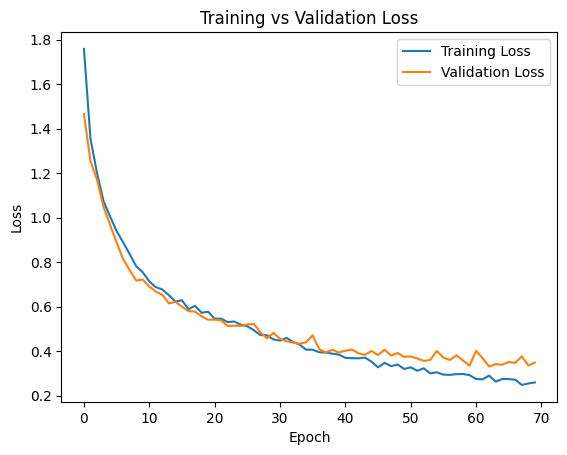

In [19]:
# Plot Training vs. Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [20]:
# Evaluate on Test Set
model.load_weights(checkpoint_path)
y_pred = model.predict(X_test[..., np.newaxis]).argmax(axis=1)

print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.32      0.64      0.43        77
           1       0.58      0.38      0.46        78
           2       0.42      0.21      0.28        81
           3       0.41      0.54      0.47        79
           4       0.57      0.44      0.50        77
           5       0.99      1.00      1.00       336
           6       0.92      0.97      0.95       334
           7       0.99      0.94      0.96       335
           8       0.82      0.70      0.76        73
           9       0.98      1.00      0.99       154
          10       0.93      0.89      0.91       307

    accuracy                           0.84      1931
   macro avg       0.72      0.70      0.70      1931
weighted avg       0.85      0.84      0.84      1931



# Fusing image + rp for ankle acceleration and angular velocity magnitudes. Then training and testing

In [21]:
import zipfile
import os

# Paths to the uploaded ZIP files
rp_images_zip_path = '/content/drive/My Drive/IS/rp_images_resized.zip'
summed_diff_zip_path = '/content/drive/My Drive/IS/summed_diff_images.zip'

# Unzip paths
unzip_rp_images_path = '/content/'
unzip_summed_diff_path = '/content/'

# Extract RP images
with zipfile.ZipFile(rp_images_zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_rp_images_path)

# Extract summed difference images
with zipfile.ZipFile(summed_diff_zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_summed_diff_path)

print("Extraction completed.")

Extraction completed.


In [24]:
!pip install opencv-python

In [29]:
import numpy as np
import cv2

# Define paths
rp_image_paths = {
    "trial1": os.path.join(unzip_rp_images_path, "trial1_sensor_rp_images_resized"),
    "trial2": os.path.join(unzip_rp_images_path, "trial2_sensor_rp_images_resized"),
    "trial3": os.path.join(unzip_rp_images_path, "trial3_sensor_rp_images_resized"),
}

summed_diff_paths = {
    "trial1": os.path.join(unzip_summed_diff_path, "trial1_summed_diff_images"),
    "trial2": os.path.join(unzip_summed_diff_path, "trial2_summed_diff_images"),
    "trial3": os.path.join(unzip_summed_diff_path, "trial3_summed_diff_images"),
}

# Output path for fused images
fused_images_output_path = '/content/fused_images'
os.makedirs(fused_images_output_path, exist_ok=True)

# Function to fuse RP and summed-diff images
def fuse_images(rp_dir, sd_dir, output_dir):
    for root, _, files in os.walk(sd_dir):
        for file in files:
            if file.endswith(".jpg"):
                # Extract identifiers from file path
                subject_activity_trial = os.path.basename(root)  # Example: Subject1_Activity1_Trial1
                window_id = file.split("_")[0]  # Example: window0

                # Paths to RP images
                rp_acc_path = os.path.join(rp_dir, subject_activity_trial, f"{window_id}_acc.npy")
                rp_gyro_path = os.path.join(rp_dir, subject_activity_trial, f"{window_id}_gyro.npy")
                summed_diff_path = os.path.join(root, file)

                # Check if all required files exist
                if os.path.exists(rp_acc_path) and os.path.exists(rp_gyro_path) and os.path.exists(summed_diff_path):
                    # Load images
                    rp_acc = np.load(rp_acc_path)
                    rp_gyro = np.load(rp_gyro_path)
                    summed_diff = cv2.imread(summed_diff_path, cv2.IMREAD_GRAYSCALE)

                    # Fuse images as channels
                    fused_image = np.stack([summed_diff, rp_acc, rp_gyro], axis=-1)

                    # Save fused image as .npy
                    output_subdir = os.path.join(output_dir, subject_activity_trial)
                    os.makedirs(output_subdir, exist_ok=True)
                    output_file = os.path.join(output_subdir, f"{window_id}_fused.npy")
                    np.save(output_file, fused_image)

# Fuse images for all trials
for trial, rp_path in rp_image_paths.items():
    sd_path = summed_diff_paths[trial]
    trial_output_path = os.path.join(fused_images_output_path, f"{trial}_fused_images")
    os.makedirs(trial_output_path, exist_ok=True)
    fuse_images(rp_path, sd_path, trial_output_path)

print("Fusion completed.")

Fusion completed.


In [30]:
# Save fused images to Google Drive
fused_images_drive_path = '/content/drive/My Drive/IS/fused_images_rp_summed_diff.zip'
!zip -r "$fused_images_drive_path" "$fused_images_output_path"

print("Fused images saved to Google Drive.")

Streaming output truncated to the last 5000 lines.
  adding: content/fused_images/trial2_fused_images/Subject11_Activity8_Trial2/window4_fused.npy (deflated 42%)
  adding: content/fused_images/trial2_fused_images/Subject11_Activity8_Trial2/window5_fused.npy (deflated 42%)
  adding: content/fused_images/trial2_fused_images/Subject11_Activity8_Trial2/window19_fused.npy (deflated 38%)
  adding: content/fused_images/trial2_fused_images/Subject11_Activity8_Trial2/window13_fused.npy (deflated 37%)
  adding: content/fused_images/trial2_fused_images/Subject11_Activity8_Trial2/window0_fused.npy (deflated 38%)
  adding: content/fused_images/trial2_fused_images/Subject11_Activity8_Trial2/window3_fused.npy (deflated 39%)
  adding: content/fused_images/trial2_fused_images/Subject11_Activity8_Trial2/window6_fused.npy (deflated 42%)
  adding: content/fused_images/trial2_fused_images/Subject11_Activity8_Trial2/window14_fused.npy (deflated 38%)
  adding: content/fused_images/trial2_fused_images/Subject

In [33]:
from sklearn.model_selection import train_test_split
import numpy as np
import os

# Function to load fused data
def load_fused_data(fused_path):
    data = []
    labels = []
    skipped_files = 0

    for root, _, files in os.walk(fused_path):
        for file in files:
            if file.endswith('.npy'):
                file_path = os.path.join(root, file)
                fused_image = np.load(file_path)

                # Extract activity label from the parent folder structure
                try:
                    folder_name = os.path.basename(root)  # Example: Subject10_Activity10_Trial1
                    activity_part = folder_name.split("_")[1]  # Extracts 'Activity10'
                    activity_label = int(activity_part.replace('Activity', '')) - 1  # Convert to 0-based indexing

                    data.append(fused_image)
                    labels.append(activity_label)
                except (IndexError, ValueError) as e:
                    print(f"Skipping file {file_path} due to parsing error: {e}")
                    skipped_files += 1

    print(f"Loaded {len(data)} fused images with labels. Skipped {skipped_files} files.")
    return np.array(data), np.array(labels)


# Load data for each trial
trial1_data, trial1_labels = load_fused_data(os.path.join(fused_images_output_path, "trial1_fused_images"))
trial2_data, trial2_labels = load_fused_data(os.path.join(fused_images_output_path, "trial2_fused_images"))
trial3_data, trial3_labels = load_fused_data(os.path.join(fused_images_output_path, "trial3_fused_images"))

# Combine trial1 and trial2 for training
X_train_val = np.concatenate((trial1_data, trial2_data), axis=0)
y_train_val = np.concatenate((trial1_labels, trial2_labels), axis=0)

# Trial 3 for testing
X_test = trial3_data
y_test = trial3_labels

# Split training and validation sets from the combined data
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Verify dataset shapes
print("Training data shape:", X_train.shape, "Training labels shape:", y_train.shape)
print("Validation data shape:", X_val.shape, "Validation labels shape:", y_val.shape)
print("Test data shape:", X_test.shape, "Test labels shape:", y_test.shape)

Loaded 1961 fused images with labels. Skipped 0 files.
Loaded 1915 fused images with labels. Skipped 0 files.
Loaded 1931 fused images with labels. Skipped 0 files.
Training data shape: (3100, 32, 32, 3) Training labels shape: (3100,)
Validation data shape: (776, 32, 32, 3) Validation labels shape: (776,)
Test data shape: (1931, 32, 32, 3) Test labels shape: (1931,)


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Define CNN model
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,331 (626.29 KB)

 Trainable params: 160,331 (626.29 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Define callbacks
checkpoint_path = "/content/best_model_fused_images.keras"
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=70,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.2045 - loss: 5.6708 - val_accuracy: 0.4742 - val_loss: 1.9522
Epoch 2/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3916 - loss: 1.7588 - val_accuracy: 0.5477 - val_loss: 1.5969
Epoch 3/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5139 - loss: 1.4607 - val_accuracy: 0.5915 - val_loss: 1.3151
Epoch 4/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5910 - loss: 1.2370 - val_accuracy: 0.6430 - val_loss: 1.1751
Epoch 5/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5859 - loss: 1.2097 - val_accuracy: 0.6791 - val_loss: 1.0163
Epoch 6/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6441 - loss: 1.0614 - val_accuracy: 0.6843 - val_loss: 0.9255
Epoch 7/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7100 - loss: 0.9401 - val_accuracy: 0.7436 - val_loss: 0.8075
Epoch 8/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7232 - loss: 0.8727 - val_accuracy: 0.7577 - val_los

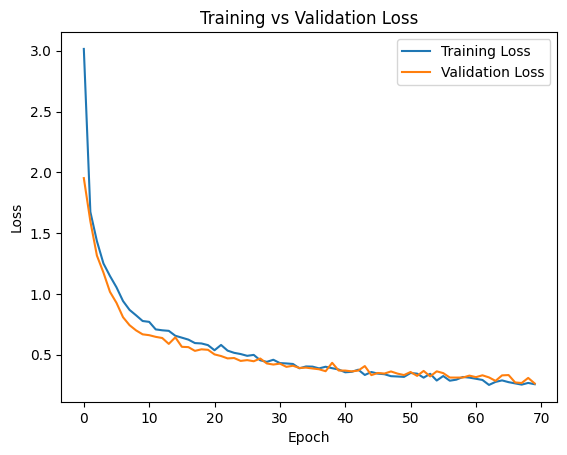

In [36]:
# Plot Training vs. Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [37]:
# Load the best model
model.load_weights(checkpoint_path)

In [38]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions
y_pred = model.predict(X_test).argmax(axis=1)

# Classification Report
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.53      0.32      0.40        77
           1       0.54      0.58      0.56        78
           2       0.35      0.35      0.35        81
           3       0.40      0.65      0.50        79
           4       0.60      0.57      0.59        77
           5       1.00      0.99      1.00       336
           6       0.97      0.95      0.96       334
           7       0.98      0.96      0.97       335
           8       0.81      0.86      0.83        73
           9       0.97      1.00      0.99       154
          10       0.98      0.94      0.96       307

    accuracy                           0.87      1931
   macro avg       0.74      0.74      0.74      1931
weighted avg       0.87      0.87      0.87      1931

Confusion Matrix:
[[ 25  15  23  10   4   0   0   0   0   0   0]
 [  9  45   4  15   3   0   0   0   1   0   1]
 

# Using GAF + SG

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import zipfile
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report

# Paths in Google Drive
zip_path = '/content/drive/My Drive/IS/fused_gaf_sd.zip'  # Path to the uploaded zip file
unzip_path = '/content/fused_gaf_sd/'  # Extraction directory

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

# Define paths for trials
trial1_path = os.path.join(unzip_path, 'fused_gaf_sd','trial1_fused_images')
trial2_path = os.path.join(unzip_path, 'fused_gaf_sd','trial2_fused_images')
trial3_path = os.path.join(unzip_path, 'fused_gaf_sd','trial3_fused_images')

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [7]:
# Correct paths
trial1_path = "/content/fused_gaf_sd/fused_gaf_sd/trial1_fused_images"
trial2_path = "/content/fused_gaf_sd/fused_gaf_sd/trial2_fused_images"
trial3_path = "/content/fused_gaf_sd/fused_gaf_sd/trial3_fused_images"

In [9]:
# Function to load fused data
def load_fused_data(fused_path):
    data = []
    labels = []
    skipped = 0

    for root, _, files in os.walk(fused_path):
        for file in files:
            if file.endswith('.npy'):
                try:
                    # Load fused image
                    fused_image = np.load(os.path.join(root, file))

                    # Parse the folder name to extract the activity label
                    folder_name = os.path.basename(root)
                    activity_label = int([part for part in folder_name.split('_') if "Activity" in part][0].replace('Activity', '')) - 1

                    data.append(fused_image)
                    labels.append(activity_label)
                except Exception as e:
                    print(f"Skipping file {file} due to error: {e}")
                    skipped += 1

    print(f"Loaded {len(data)} fused images with labels. Skipped {skipped} files.")
    return np.array(data), np.array(labels)

# Load data for each trial
X_trial1, y_trial1 = load_fused_data(trial1_path)
X_trial2, y_trial2 = load_fused_data(trial2_path)
X_trial3, y_trial3 = load_fused_data(trial3_path)

# Combine trial 1 and trial 2 data for training and validation
X_train_val = np.concatenate((X_trial1, X_trial2), axis=0)
y_train_val = np.concatenate((y_trial1, y_trial2), axis=0)

# Split training and validation data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Print data shapes
print(f"Training data shape: {X_train.shape} Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape} Validation labels shape: {y_val.shape}")
print(f"Test data shape: {X_trial3.shape} Test labels shape: {y_trial3.shape}")

Loaded 1961 fused images with labels. Skipped 0 files.
Loaded 1915 fused images with labels. Skipped 0 files.
Loaded 1931 fused images with labels. Skipped 0 files.
Training data shape: (3100, 32, 32, 3) Training labels shape: (3100,)
Validation data shape: (776, 32, 32, 3) Validation labels shape: (776,)
Test data shape: (1931, 32, 32, 3) Test labels shape: (1931,)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Define the CNN model
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.4),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
# Get input shape and number of classes
input_shape = X_train.shape[1:]  # Assuming X_train has shape (samples, 32, 32, 3)
num_classes = len(np.unique(y_train))

# Create the model
model = create_model(input_shape, num_classes)

# Define callbacks
checkpoint_path = "/content/best_model_gaf_sd.keras"
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=70,
    batch_size=16,
    callbacks=[early_stopping, model_checkpoint]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/70
194/194 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.1892 - loss: 5.0389 - val_accuracy: 0.4987 - val_loss: 1.7174
Epoch 2/70
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4740 - loss: 1.5884 - val_accuracy: 0.5838 - val_loss: 1.3470
Epoch 3/70
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5332 - loss: 1.4183 - val_accuracy: 0.6418 - val_loss: 1.3173
Epoch 4/70
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5847 - loss: 1.2696 - val_accuracy: 0.6353 - val_loss: 1.0851
Epoch 5/70
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6441 - loss: 1.0902 - val_accuracy: 0.7010 - val_loss: 0.9336
Epoch 6/70
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6755 - loss: 1.0051 - val_accuracy: 0.7216 - val_loss: 0.8714
Epoch 7/70
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7192 - loss: 0.8758 - val_accuracy: 0.7668 - val_loss: 0.7625
Epoch 8/70
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7426 - loss: 0.7993 - val_accuracy: 

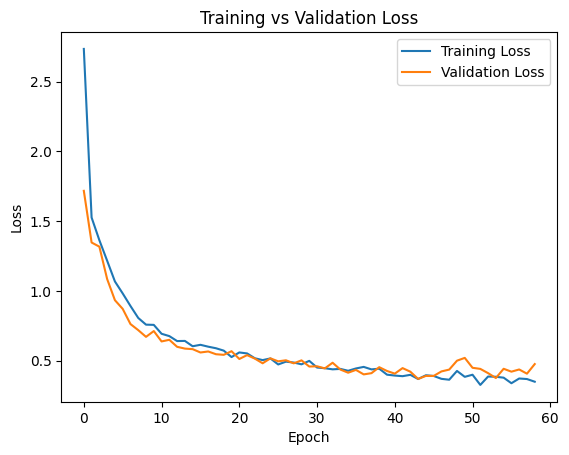

In [12]:
# Plot Training vs. Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [13]:
# Load the best model
model.load_weights(checkpoint_path)

# Predict on the test set
y_pred = model.predict(X_trial3).argmax(axis=1)

# Classification report
print("Classification Report on Test Set:")
print(classification_report(y_trial3, y_pred))

# Save the model
model.save("/content/drive/My Drive/IS/best_model_gaf_sd.keras")

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.68      0.35      0.46        77
           1       0.46      0.65      0.54        78
           2       0.40      0.25      0.31        81
           3       0.51      0.47      0.49        79
           4       0.53      0.60      0.56        77
           5       0.99      0.99      0.99       336
           6       0.94      0.96      0.95       334
           7       0.97      0.98      0.98       335
           8       0.82      0.70      0.76        73
           9       0.95      1.00      0.97       154
          10       0.86      0.94      0.90       307

    accuracy                           0.86      1931
   macro avg       0.74      0.72      0.72      1931
weighted avg       0.85      0.86      0.85      1931



# Adding more sensor data (SD + RP_ankle + RP_wrist)

In [1]:
# Mount Google Drive
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

# Path to the dataset zip file in Google Drive
zip_path = '/content/drive/My Drive/IS/fused_images_rp_sd_ankle_wrist.zip'
unzip_path = '/content/fused_images_rp_sd_ankle_wrist'

# Extract the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

print("Dataset extracted.")

Mounted at /content/drive
Dataset extracted.


In [2]:
import numpy as np
import os

# Paths for each trial
trial_paths = {
    "trial1": os.path.join(unzip_path, 'fused_images_rp_sd_ankle_wrist',"trial1_fused_images"),
    "trial2": os.path.join(unzip_path, 'fused_images_rp_sd_ankle_wrist',"trial2_fused_images"),
    "trial3": os.path.join(unzip_path, 'fused_images_rp_sd_ankle_wrist',"trial3_fused_images")
}

# Function to load fused data
def load_fused_data(fused_path):
    data = []
    labels = []
    skipped = 0

    for root, _, files in os.walk(fused_path):
        for file in files:
            if file.endswith('.npy'):
                try:
                    fused_image = np.load(os.path.join(root, file))

                    # Extract activity label from folder structure
                    relative_path = os.path.relpath(root, fused_path)
                    activity_label = int([part for part in relative_path.split('_') if "Activity" in part][0].replace('Activity', '')) - 1

                    data.append(fused_image)
                    labels.append(activity_label)
                except Exception as e:
                    print(f"Skipping file {file} due to error: {e}")
                    skipped += 1

    print(f"Loaded {len(data)} fused images with labels. Skipped {skipped} files.")
    return np.array(data), np.array(labels)

# Load data for each trial
trial1_data, trial1_labels = load_fused_data(trial_paths["trial1"])
trial2_data, trial2_labels = load_fused_data(trial_paths["trial2"])
trial3_data, trial3_labels = load_fused_data(trial_paths["trial3"])

print("Data loading complete.")

Loaded 1961 fused images with labels. Skipped 0 files.
Loaded 1915 fused images with labels. Skipped 0 files.
Loaded 1931 fused images with labels. Skipped 0 files.
Data loading complete.


In [3]:
from sklearn.model_selection import train_test_split

# Combine trial1 and trial2 for training and validation
X_train_val = np.concatenate((trial1_data, trial2_data), axis=0)
y_train_val = np.concatenate((trial1_labels, trial2_labels), axis=0)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Use trial3 as the test set
X_test, y_test = trial3_data, trial3_labels

# Verify shapes
print("Training data shape:", X_train.shape, "Training labels shape:", y_train.shape)
print("Validation data shape:", X_val.shape, "Validation labels shape:", y_val.shape)
print("Test data shape:", X_test.shape, "Test labels shape:", y_test.shape)

Training data shape: (3100, 32, 32, 5) Training labels shape: (3100,)
Validation data shape: (776, 32, 32, 5) Validation labels shape: (776,)
Test data shape: (1931, 32, 32, 5) Test labels shape: (1931,)


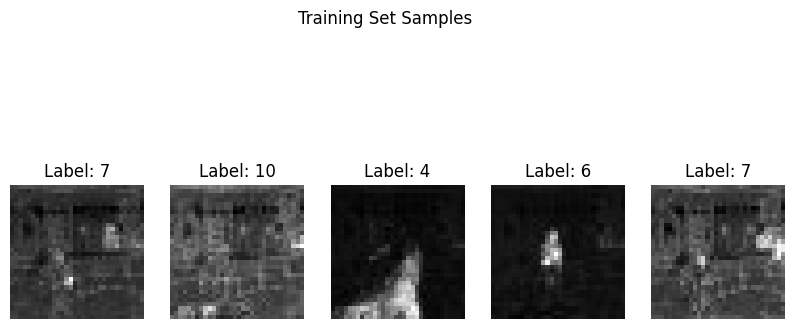

In [4]:
import matplotlib.pyplot as plt

# Function to display random samples
def display_random_samples(X, y, title="Samples"):
    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i][..., 0], cmap='gray')  # Display the first channel
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display training samples
display_random_samples(X_train, y_train, title="Training Set Samples")

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report

# Define model architecture
num_classes = len(np.unique(y_train))
input_shape = X_train.shape[1:]

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_path = "/content/best_model_rp_sd_ankle_wrist.keras"
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.2315 - loss: 5.3329 - val_accuracy: 0.4742 - val_loss: 1.6914
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.4385 - loss: 1.6186 - val_accuracy: 0.5554 - val_loss: 1.3663
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5531 - loss: 1.3161 - val_accuracy: 0.6379 - val_loss: 1.1621
Epoch 4/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6027 - loss: 1.2021 - val_accuracy: 0.6521 - val_loss: 1.0329
Epoch 5/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6436 - loss: 1.0815 - val_accuracy: 0.7049 - val_loss: 0.8687
Epoch 6/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6914 - loss: 0.9977 - val_accuracy: 0.7204 - val_loss: 0.8221
Epoch 7/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7136 - loss: 0.8641 - val_accuracy: 0.7603 - val_loss: 0.7268
Epoch 8/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7357 - loss: 0.8058 - val_accuracy:

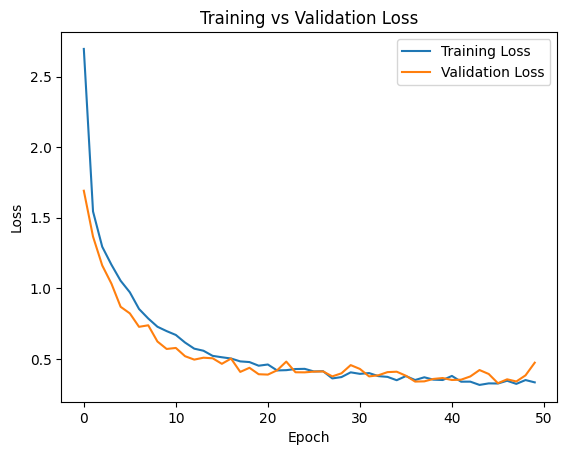

In [6]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [7]:
# Evaluate on test set
model.load_weights(checkpoint_path)
y_pred = model.predict(X_test).argmax(axis=1)

print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.53      0.38      0.44        77
           1       0.57      0.40      0.47        78
           2       0.35      0.47      0.40        81
           3       0.39      0.65      0.49        79
           4       0.69      0.40      0.51        77
           5       1.00      0.99      1.00       336
           6       0.98      0.98      0.98       334
           7       0.98      0.98      0.98       335
           8       0.96      0.92      0.94        73
           9       0.96      1.00      0.98       154
          10       0.97      0.96      0.97       307

    accuracy                           0.87      1931
   macro avg       0.76      0.74      0.74      1931
weighted avg       0.88      0.87      0.87      1931



# Exploring Image Averaging and Weighted Stacking techniques for the fused_images_rp_sd_ankle_wrist dataset

In [16]:
import zipfile
import os

# Path to your zip file in Google Drive
zip_path = "/content/drive/My Drive/IS/fused_images_rp_sd_ankle_wrist.zip"
unzip_path = "/content/fused_images_rp_sd_ankle_wrist"

# Extract the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

print(f"Dataset extracted to: {unzip_path}")

Dataset extracted to: /content/fused_images_rp_sd_ankle_wrist


In [17]:
import numpy as np
import os

# Paths for each trial
trial_paths = {
    "trial1": os.path.join(unzip_path, 'fused_images_rp_sd_ankle_wrist',"trial1_fused_images"),
    "trial2": os.path.join(unzip_path, 'fused_images_rp_sd_ankle_wrist',"trial2_fused_images"),
    "trial3": os.path.join(unzip_path, 'fused_images_rp_sd_ankle_wrist',"trial3_fused_images")
}

# Function to load fused data
def load_fused_data(fused_path):
    data = []
    labels = []
    skipped = 0

    for root, _, files in os.walk(fused_path):
        for file in files:
            if file.endswith('.npy'):
                try:
                    fused_image = np.load(os.path.join(root, file))

                    # Extract activity label from folder structure
                    relative_path = os.path.relpath(root, fused_path)
                    activity_label = int([part for part in relative_path.split('_') if "Activity" in part][0].replace('Activity', '')) - 1

                    data.append(fused_image)
                    labels.append(activity_label)
                except Exception as e:
                    print(f"Skipping file {file} due to error: {e}")
                    skipped += 1

    print(f"Loaded {len(data)} fused images with labels. Skipped {skipped} files.")
    return np.array(data), np.array(labels)

# Load data for each trial
trial1_data, trial1_labels = load_fused_data(trial_paths["trial1"])
trial2_data, trial2_labels = load_fused_data(trial_paths["trial2"])
trial3_data, trial3_labels = load_fused_data(trial_paths["trial3"])

print("Data loading complete.")

Loaded 1961 fused images with labels. Skipped 0 files.
Loaded 1915 fused images with labels. Skipped 0 files.
Loaded 1931 fused images with labels. Skipped 0 files.
Data loading complete.


In [18]:
# Combine trial1 and trial2 for training and validation
X_train_val = np.concatenate((trial1_data, trial2_data), axis=0)
y_train_val = np.concatenate((trial1_labels, trial2_labels), axis=0)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Use trial3 as the test set
X_test, y_test = trial3_data, trial3_labels

# Verify shapes
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Validation labels shape: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")

Training data shape: (3100, 32, 32, 5), Training labels shape: (3100,)
Validation data shape: (776, 32, 32, 5), Validation labels shape: (776,)
Test data shape: (1931, 32, 32, 5), Test labels shape: (1931,)


In [19]:
def fuse_images_with_averaging(data):
    fused_data = np.mean(data, axis=-1, keepdims=True)
    return fused_data

# Apply image averaging
X_train_avg = fuse_images_with_averaging(X_train)
X_val_avg = fuse_images_with_averaging(X_val)
X_test_avg = fuse_images_with_averaging(X_test)

print(f"Averaged Training data shape: {X_train_avg.shape}")

Averaged Training data shape: (3100, 32, 32, 1)


In [20]:
def fuse_images_with_weighted_stacking(data, weights):
    weighted_data = np.zeros_like(data[..., 0])
    for i, weight in enumerate(weights):
        weighted_data += data[..., i] * weight
    return weighted_data[..., np.newaxis]

# Define weights (adjust these as needed)
weights = [0.4, 0.3, 0.1, 0.1, 0.1]  # Example: prioritize ankle RP, wrist RP, then summed-diff

# Apply weighted stacking
X_train_weighted = fuse_images_with_weighted_stacking(X_train, weights)
X_val_weighted = fuse_images_with_weighted_stacking(X_val, weights)
X_test_weighted = fuse_images_with_weighted_stacking(X_test, weights)

print(f"Weighted Training data shape: {X_train_weighted.shape}")

Weighted Training data shape: (3100, 32, 32, 1)


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define CNN model
def build_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train and evaluate for a given dataset
def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, checkpoint_path):
    input_shape = X_train.shape[1:]
    num_classes = len(np.unique(y_train))

    model = build_model(input_shape, num_classes)

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True)

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping, model_checkpoint]
    )

    # Evaluate
    model.load_weights(checkpoint_path)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    return history

In [22]:
# For Image Averaging
train_and_evaluate(
    X_train_avg, y_train,
    X_val_avg, y_val,
    X_test_avg, y_test,
    "/content/best_model_avg.keras"
)

# For Weighted Stacking
train_and_evaluate(
    X_train_weighted, y_train,
    X_val_weighted, y_val,
    X_test_weighted, y_test,
    "/content/best_model_weighted.keras"
)

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.3667 - loss: 1.9448 - val_accuracy: 0.6572 - val_loss: 1.1772
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6310 - loss: 1.1395 - val_accuracy: 0.7126 - val_loss: 0.8974
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6990 - loss: 0.9599 - val_accuracy: 0.7577 - val_loss: 0.7523
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7434 - loss: 0.8179 - val_accuracy: 0.7848 - val_loss: 0.6830
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7550 - loss: 0.7357 - val_accuracy: 0.7938 - val_loss: 0.6262
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7757 - loss: 0.6705 - val_accuracy: 0.8131 - val_loss: 0.5722
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7925 - loss: 0.6131 - val_accuracy: 0.8235 - val_loss: 0.5238
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8015 - loss: 0.5801 - val_accuracy: 0.8209 - val_loss

# Fine-tuning weights (TO BE DELETED)

In [23]:
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [24]:
# Function to apply weighted stacking
def fuse_images_with_weighted_stacking(data, weights):
    weighted_data = np.zeros_like(data[..., 0])
    for i, weight in enumerate(weights):
        weighted_data += data[..., i] * weight
    return weighted_data[..., np.newaxis]

In [25]:
# Function to build and train the model
def train_and_evaluate_model(X_train_weighted, y_train, X_val_weighted, y_val, X_test_weighted, y_test):
    num_classes = len(np.unique(y_train))

    # Model architecture
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=X_train_weighted.shape[1:]),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.4),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    # Compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

    # Train the model
    model.fit(
        X_train_weighted, y_train,
        validation_data=(X_val_weighted, y_val),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0  # Suppress detailed training logs for weight optimization
    )

    # Evaluate on the test set
    y_pred = model.predict(X_test_weighted).argmax(axis=1)
    return accuracy_score(y_test, y_pred)

In [26]:
# Function to optimize weights
def optimize_weights(X_train, y_train, X_val, y_val, X_test, y_test):
    # Define the objective function for weight optimization
    def objective(weights):
        X_train_weighted = fuse_images_with_weighted_stacking(X_train, weights)
        X_val_weighted = fuse_images_with_weighted_stacking(X_val, weights)
        X_test_weighted = fuse_images_with_weighted_stacking(X_test, weights)
        accuracy = train_and_evaluate_model(X_train_weighted, y_train, X_val_weighted, y_val, X_test_weighted, y_test)
        return -accuracy  # Negative because we want to maximize accuracy

    # Initial weights (equal distribution)
    initial_weights = np.ones(X_train.shape[-1]) / X_train.shape[-1]

    # Constraints: Weights should sum to 1
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

    # Bounds for weights (0 to 1)
    bounds = [(0, 1)] * X_train.shape[-1]

    # Optimize weights using minimize
    result = minimize(
        objective,
        initial_weights,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'disp': True}
    )

    return result.x, -result.fun  # Return optimal weights and best accuracy

In [28]:
# Run weight optimization
optimal_weights, best_accuracy = optimize_weights(X_train, y_train, X_val, y_val, X_test, y_test)

print(f"Optimal Weights: {optimal_weights}")
print(f"Best Accuracy Achieved: {best_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.8565510098394614
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 1
Optimal Weights: [0.2 0.2 0.2 0.2 0.2]
Best Accuracy Achieved: 0.8566
